# WOfS Validation Accuracy Assessment <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2),
[ga_ls8c_wofs_2_summary ](https://explorer.digitalearth.africa/ga_ls8c_wofs_2_summary)

## Background
Accuracy assessment for WOfS product in Africa includes generating a confusion error matrix for a WOFL binary classification.
The inputs for the estimating the accuracy of WOfS derived product are a binary classification WOFL layer showing water/non-water and a shapefile containing validation points collected by [Collect Earth Online](https://collect.earth/) tool. Validation points are the ground truth or actual data while the extracted value for each location from WOFL is the predicted value. A confusion error matrix containing overall, producer's and user's accuracy is the output of this analysis. 

## Description
This notebook explains how you can perform accuracy assessment for WOFS derived product using collected ground truth dataset. 

The notebook demonstrates how to:
1. Generating a confusion error matrix for WOFL binary classification
2. Assessing the accuracy of the classification 
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

### Load packages
Import Python packages that are used for the analysis.

In [28]:
%matplotlib inline

import time 
import datacube
from datacube.utils import masking, geometry 
import sys
import os
import dask 
import rasterio, rasterio.features
import xarray
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import subprocess as sp
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

sys.path.append("../Scripts")
from rasterio.mask import mask
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import plot_confusion_matrix, f1_score  
from deafrica_plotting import map_shapefile,display_map, rgb
from deafrica_spatialtools import xr_rasterize
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard,deepcopy
from deafrica_dask import create_local_dask_cluster

### Loading Dataset

Read in the validation data csv, clean the table and rename the column associated with actual and predicted. 

We need to read two columns from this table:
- Water flag as the groundtruth(actual)
- Class Wet from WOfS (prediction)

In [29]:
#Read the ground truth data following analysis step 
CEO = '../Supplementary_data/Validation/Refined/OSS/OSS_points_SCL_5D.csv'
# CEO = '../Supplementary_data/Validation/Refined/AFRIGIST/Groundtruth_AfriGIST_W305m.csv'
df = pd.read_csv(CEO,delimiter=",")

In [30]:
df.columns

Index(['Unnamed: 0', 'PLOT_ID', 'LON', 'LAT', 'FLAGGED', 'ANALYSES',
       'SENTINEL2Y', 'STARTDATE', 'ENDDATE', 'WATER', 'NO_WATER', 'BAD_IMAGE',
       'NOT_SURE', 'CLASS', 'COMMENT', 'MONTH', 'WATERFLAG', 'geometry',
       'CLASS_WET', 'CLEAR_OBS'],
      dtype='object')

In [31]:
input_data = df.drop(['Unnamed: 0', 'FLAGGED', 'ANALYSES','SENTINEL2Y','STARTDATE', 'ENDDATE', 'WATER', 'NO_WATER', 'BAD_IMAGE', 'NOT_SURE','COMMENT','geometry'], axis=1)
input_data = input_data.rename(columns={'WATERFLAG':'ACTUAL'})

In [32]:
input_data

,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLEAR_OBS
0,137755802.0,-0.260555,16.620471,I am unsure,1,1,0.0,2.0
1,137755802.0,-0.260555,16.620471,I am unsure,3,1,1.0,1.0
2,137755802.0,-0.260555,16.620471,I am unsure,11,1,1.0,1.0
3,137755802.0,-0.260555,16.620471,I am unsure,12,1,1.0,2.0
4,137755803.0,-14.230417,16.545471,I am unsure,6,0,0.0,1.0
...,...,...,...,...,...,...,...,...
3781,137755559.0,29.759257,31.046130,Open water - Constructed (e.g. aquaculture),7,1,0.0,2.0
3782,137755559.0,29.759257,31.046130,Open water - Constructed (e.g. aquaculture),9,1,0.0,1.0
3783,137755559.0,29.759257,31.046130,Open water - Constructed (e.g. aquaculture),11,1,1.0,1.0
3784,137755560.0,32.430103,31.028901,Cultivated (Cropland/ Plantation),6,0,0.0,1.0


In [33]:
#setting the column prediction based on frequency flag or using class_wet flag 
#input_data['PREDICTION'] = input_data['FREQUENCY'].apply(lambda x: '1' if x > 0.5 else '0')
input_data['PREDICTION'] = input_data['CLASS_WET'].apply(lambda x: '1' if x >=1 else '0') #you need to comment after this 

In [34]:
geometry = [Point(xy) for xy in zip(input_data.LON, input_data.LAT)]
crs = {'init': 'epsg:4326'} 
ValPoints = GeoDataFrame(input_data, crs=crs, geometry=geometry)

In [35]:
#Reading the boundary file for African countries 
aez = '../Supplementary_data/Validation/Refined/shapefiles/African_countries_Dissolve.shp'

In [36]:
outline = gpd.read_file(aez).to_crs('EPSG:4326')
#outline

In [37]:
#Setting the buffer zone to exclude points that are located in intertidal areas 
buffer_zone = outline.buffer(-0.02,resolution=16)

In [38]:
#Clipping the input data with the buffer zone to have all inland points that are not coastal 
include_points = gpd.clip(ValPoints, buffer_zone)

In [39]:
# the list of include points 
include_points 

,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLEAR_OBS,PREDICTION,geometry
0,137755802.0,-0.260555,16.620471,I am unsure,1,1,0.0,2.0,0,POINT (-0.26056 16.62047)
1,137755802.0,-0.260555,16.620471,I am unsure,3,1,1.0,1.0,1,POINT (-0.26056 16.62047)
2,137755802.0,-0.260555,16.620471,I am unsure,11,1,1.0,1.0,1,POINT (-0.26056 16.62047)
3,137755802.0,-0.260555,16.620471,I am unsure,12,1,1.0,2.0,1,POINT (-0.26056 16.62047)
4,137755803.0,-14.230417,16.545471,I am unsure,6,0,0.0,1.0,0,POINT (-14.23042 16.54547)
...,...,...,...,...,...,...,...,...,...,...
3781,137755559.0,29.759257,31.046130,Open water - Constructed (e.g. aquaculture),7,1,0.0,2.0,0,POINT (29.75926 31.04613)
3782,137755559.0,29.759257,31.046130,Open water - Constructed (e.g. aquaculture),9,1,0.0,1.0,0,POINT (29.75926 31.04613)
3783,137755559.0,29.759257,31.046130,Open water - Constructed (e.g. aquaculture),11,1,1.0,1.0,1,POINT (29.75926 31.04613)
3784,137755560.0,32.430103,31.028901,Cultivated (Cropland/ Plantation),6,0,0.0,1.0,0,POINT (32.43010 31.02890)


In [41]:
include_points.to_file(filename='../Supplementary_data/Validation/Refined/OSS/OSS_inland_S2_SCL_5D.shp') 

In [42]:
include_points.to_file('../Supplementary_data/Validation/Refined/OSS/shapefile/OSS_inland_S2_SCL_5D.geojson',driver='GeoJSON') 

In [43]:
include_points.to_csv(('../Supplementary_data/Validation/Refined/OSS/OSS_inland_S2_SCL_5D.csv')) #this will be used for initial accuracy assessment 

In [44]:
FN = include_points[(include_points['ACTUAL']==1) & (input_data['PREDICTION']=='0')][['PLOT_ID','LAT','LON','CLASS','MONTH','ACTUAL','PREDICTION']]

In [45]:
FN

,PLOT_ID,LAT,LON,CLASS,MONTH,ACTUAL,PREDICTION
0,137755802.0,16.620471,-0.260555,I am unsure,1,1,0
6,137755803.0,16.545471,-14.230417,I am unsure,2,1,0
7,137755803.0,16.545471,-14.230417,I am unsure,3,1,0
11,137755805.0,16.473684,-0.115353,Wetlands - freshwater,1,1,0
15,137755806.0,16.388211,-3.217452,Wetlands - freshwater,11,1,0
...,...,...,...,...,...,...,...
3778,137755559.0,31.046130,29.759257,Open water - Constructed (e.g. aquaculture),4,1,0
3779,137755559.0,31.046130,29.759257,Open water - Constructed (e.g. aquaculture),5,1,0
3780,137755559.0,31.046130,29.759257,Open water - Constructed (e.g. aquaculture),6,1,0
3781,137755559.0,31.046130,29.759257,Open water - Constructed (e.g. aquaculture),7,1,0


In [46]:
FN.to_csv(('../Supplementary_data/Validation/Refined/OSS/FalseNegative_OSS_PointAnalysis__S2_SCL_5D.csv'))

### Calculate confusion matrix on inland points 

To do the accuracy assesssment of the validation in each AEZ , we need to obtain WOfS surface water observation data that corresponds with the labelled input data locations. 

In [47]:
#RCMRD_inland
confusion_matrix = pd.crosstab(include_points['ACTUAL'],include_points['PREDICTION'],rownames=['ACTUAL'],colnames=['PREDICTION'],margins=True)
confusion_matrix

PREDICTION,0,1,All
ACTUAL,,,
0,1735,83,1818
1,655,742,1397
All,2390,825,3215


### Calculating User's Accuracy 

The User's Accuracy is the accuracy from the point of view of a map user, not the map maker. the User's accuracy essentially tells use how often the class on the map will actually be present on the ground. This is referred to as reliability. The User's Accuracy is complement of the Commission Error, *User's Accuracy = 100%-Commission Error*. The User's Accuracy is calculating by taking the total number of correct classifications for a particular class and dividing it by the row total.

In [48]:
confusion_matrix["User's"] = [confusion_matrix.loc[0][0] / confusion_matrix.loc[0]['All'] * 100, confusion_matrix.loc[1][1] / confusion_matrix.loc[1]['All'] *100, np.nan]
confusion_matrix

PREDICTION,0,1,All,User's
ACTUAL,,,,
0,1735,83,1818,95.434543
1,655,742,1397,53.113815
All,2390,825,3215,NaN


The false positive ones are 452 points that need to be checked against WOfS 

### Calculating Producer's Accuracy 

Producer's Accuracy is the map accuracy from the point of view of the map maker (the producer). This is how often are real features on the ground correctly shown on the classified map or the probability that a certain land cover of an area on the ground is classified as such. Deviding the number of correctly classified pixels in each category (on the major diagonal) by the numbr of reference pixels "known" to be of that category (the column total)
This value represents how well reference pixels of the ground cover type are classified. Producer's accuracy completes ommision error, *Producer's accuracy = 100% - Ommision error*

In [49]:
producers_accuracy = pd.Series([confusion_matrix['0'][0] / confusion_matrix['0']['All'] * 100,
                                confusion_matrix['1'][1] / confusion_matrix['1']['All'] * 100]).rename("Producer's")

confusion_matrix = confusion_matrix.append(producers_accuracy)
confusion_matrix 

,0,1,All,User's,0,1
ACTUAL,,,,,,
0,1735.0,83.0,1818.0,95.434543,NaN,NaN
1,655.0,742.0,1397.0,53.113815,NaN,NaN
All,2390.0,825.0,3215.0,NaN,NaN,NaN
Producer's,NaN,NaN,NaN,NaN,72.594142,89.939394


In [50]:
confusion_matrix.loc["Producer's", "User's"] = (confusion_matrix['0'][0] + confusion_matrix['1'][1]) / confusion_matrix['All']['All'] * 100
confusion_matrix

,0,1,All,User's,0,1
ACTUAL,,,,,,
0,1735.0,83.0,1818.0,95.434543,NaN,NaN
1,655.0,742.0,1397.0,53.113815,NaN,NaN
All,2390.0,825.0,3215.0,NaN,NaN,NaN
Producer's,NaN,NaN,NaN,77.045101,72.594142,89.939394


In [51]:
include_points['PREDICTION'] = include_points['PREDICTION'] .astype(str).astype(int)

In [52]:
fscore = pd.Series([(2*(confusion_matrix.loc[0]["User's"]*confusion_matrix.loc["Producer's"][0]) / (confusion_matrix.loc[0]["User's"] + confusion_matrix.loc["Producer's"][0])) / 100,
                   f1_score(include_points['ACTUAL'],include_points['PREDICTION'])]).rename("F-score")
confusion_matrix = confusion_matrix.append(fscore)

In [53]:
confusion_matrix

,0,1,All,User's,0,1
ACTUAL,,,,,,
0,1735.0,83.0,1818.0,95.434543,NaN,NaN
1,655.0,742.0,1397.0,53.113815,NaN,NaN
All,2390.0,825.0,3215.0,NaN,NaN,NaN
Producer's,NaN,NaN,NaN,77.045101,72.594142,89.939394
F-score,NaN,NaN,NaN,NaN,0.824620,0.667867


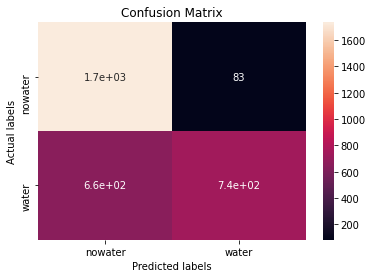

In [56]:
confusion_matrix = pd.crosstab(include_points['ACTUAL'],include_points['PREDICTION'],rownames=['ACTUAL'],colnames=['PREDICTION'])
ax = plt.subplot()
sn.heatmap(confusion_matrix, annot = True) #true to annotate cells 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels');
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['nowater','water']); ax.yaxis.set_ticklabels(['nowater','water']);
plt.show()

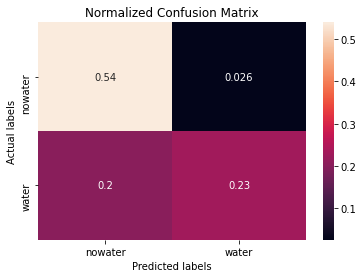

In [57]:
confusion_matrix = pd.crosstab(include_points['ACTUAL'],include_points['PREDICTION'],rownames=['ACTUAL'],colnames=['PREDICTION'],normalize=True)
ax = plt.subplot()
sn.heatmap(confusion_matrix, annot = True) #true to annotate cells 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels');
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(['nowater','water']); ax.yaxis.set_ticklabels(['nowater','water']);

In [2]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)